In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append('./scripts/')

import gzip
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from scipy.stats import mannwhitneyu

import conf
from mutrate import KEYS, set_mutrate
from plot import plot_auc_volcano
conf.config_params()

import warnings
warnings.filterwarnings('ignore')

os.makedirs("raw_plots",exist_ok=True)
os.makedirs("source_data",exist_ok=True)

# Figure 4a

In [3]:
fn = os.path.join(os.environ['PATH_SOURCE_DATA'], 'figure4-source-data', 'predicted-observed-vs-predicted-nonobserved.pickle.gz')
with gzip.open(fn, 'rb') as f:
    d = pickle.load(f)
    res_pred_obs_vs_nonobs = d['zipped_mutrate']
    auc_pred_obs_vs_nonobs = d['auc']

In [4]:
def plot_mutational_probability_bias(gene, ttype, ax):

    colors = ['#FDAE6B', '#E6550D']

    mutrates = res_pred_obs_vs_nonobs[(ttype, gene)]
    auc = auc_pred_obs_vs_nonobs[(ttype, gene)]
    
    obs = mutrates[0]
    non_obs = mutrates[1]

    x = [1] * len(non_obs) + [2] * len(obs)
    x = np.array(x) + np.random.normal(0, 0.05, size=len(x))
    y = non_obs + obs
    y = np.log10(y)
    scatter_color = [colors[0]] * len(non_obs) + [colors[1]] * len(obs)

    # boxplot

    bp = ax.boxplot([np.log10(non_obs), np.log10(obs)], 
                    showfliers=False, 
                    patch_artist=True,
                    boxprops={'alpha': 0.5},
                    widths=(0.5, 0.5),
                    medianprops={'color': 'black', 'alpha': 0.3},
                    capprops={'color': 'grey'},
                    whiskerprops={'color': 'grey'}
                )

    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    ax.set_xticklabels([f'non-obs\nN={len(non_obs)}', 
                        f'obs\nN={len(obs)}'])

    pval = mannwhitneyu(obs, non_obs)[1]
    ax.text(.9, -6.5, f'p < {np.round(pval,3)+0.001:.2e}')
    
    ax.scatter(x, y, s=5, c=scatter_color, marker='o', alpha=0.75)
    ax.set_ylabel('Mutation Probability (log)')
    ax.set_ylim(-9.5, -6)
        
    # auROC and log-fold-change
    
    y_true = [0] * len(non_obs) + [1] * len(obs)
    y_score = non_obs + obs
    
    # log-fold-change
    
    lfc = np.log10(np.median(obs) / np.median(non_obs))
    
   
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # titles
    
    ax.set_title(f'{gene} ({ttype})\n\nprob bias={np.round(auc, 2)}\nlogFC={np.round(lfc, 2)}', fontsize=10)
    
    return auc
    
   
    
def sort_axes(list_gene_ttypes):
    
    auc_list = []
    for i, (gene, ttype) in enumerate(list_gene_ttypes):
        auc = auc_pred_obs_vs_nonobs[(ttype, gene)]
        auc_list.append(auc)
    index = np.argsort(auc_list)
    return index
    
    
def panel(list_gene_ttypes):
    
    index = sort_axes(list_gene_ttypes)
    list_gene_ttypes = [list_gene_ttypes[j] for j in index][::-1]
    
    ncols = len(list_gene_ttypes) // 2
    width, height = 1.8 * (ncols), 8
    fig, ax = plt.subplots(figsize=(width, height), ncols=ncols, nrows=2)
    for i, (gene, ttype) in enumerate(list_gene_ttypes):
        row = i // 4
        col = i % 4
        auc = plot_mutational_probability_bias(gene, ttype, ax[row, col])
        if col > 0:
            ax[row, col].spines['left'].set_visible(False)
            ax[row, col].set_yticks([])
            ax[row, col].set_yticklabels([])
            ax[row, col].set_ylabel(None)
           
            
    plt.subplots_adjust(hspace=0.5)
    plt.savefig('./raw_plots/prob_bias.svg', bbox_inches='tight')
    plt.show()

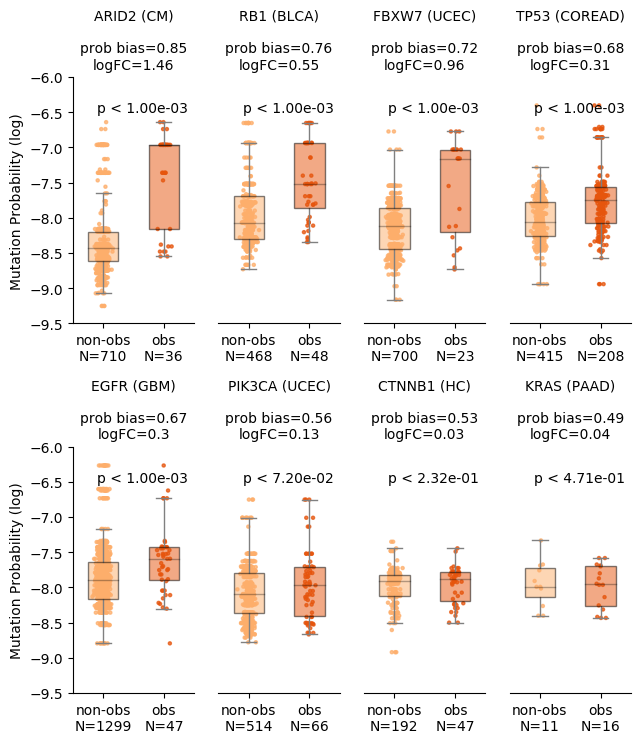

In [5]:
list_gene_ttypes = [('TP53', 'COREAD'), 
                    ('FBXW7', 'UCEC'),
                    ('KRAS', 'PAAD'),
                    ('PIK3CA', 'UCEC'),
                    ('CTNNB1', 'HC'),
                    ('RB1', 'BLCA'),
                    ('ARID2', 'CM'),
                    ('EGFR', 'GBM')
                    ]

panel(list_gene_ttypes)

# Figure 4b, Volcano plot

In [6]:
fn = os.path.join(conf.output_boostdm, 'model_selection', 'eval_data.pickle.gz')
with gzip.open(fn, 'rb') as f:
    model_dict = pickle.load(f)
    
df_drivers = pd.read_csv(conf.drivers_path, sep='\t')

In [7]:
fn = os.path.join(os.environ['PATH_SOURCE_DATA'], 'figure4-source-data', 'predicted-observed-vs-predicted-nonobserved.pickle.gz')
if not os.path.isfile(fn):
    with gzip.open(fn, 'wb') as f:
        d = {'zipped_mutrate': res, 'auc': auc}
        pickle.dump(d, f)
else:
    with gzip.open(fn, 'rb') as f:
        d = pickle.load(f)
        res = d['zipped_mutrate']
        auc = d['auc']

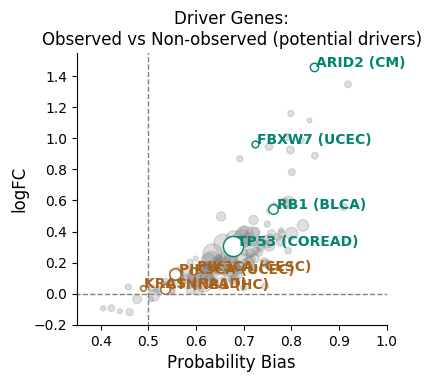

In [8]:
# plot volcano

highlight_list = [('FBXW7', 'UCEC'), ('TP53', 'COREAD'), ('RB1', 'BLCA'), ('KRAS', 'PAAD'), 
                  ('CTNNB1', 'HC'), ('PIK3CA', 'UCEC'), ('PIK3CA', 'CESC'), ('ARID2', 'CM')]

auc_obs_pred_drivers_list = plot_auc_volcano(res, auc,
                                             model_dict,
                                             df_drivers,
                                             './raw_plots/',
                                             highlight = highlight_list,
                                             title='Driver Genes:\nObserved vs Non-observed (potential drivers)',
                                             density=False,
                                             figsize=(4,4),
                                             xlim=(0.35, 1.),
                                             ylim=(-0.2, 1.55))